The below generates all the necessary imports and creates the client for using the openai or deepseek models. You can easily switch between models by changing the base_url in the client constructor.

In [2]:
from openai import OpenAI
import dotenv
import importlib
import messages
import pandas as pd


importlib.reload(messages)
from messages import messages_list
from concurrent.futures import ThreadPoolExecutor

executor = ThreadPoolExecutor()


dotenv.load_dotenv()
openai_api_key = dotenv.get_key(".env", "OPENAI_API_KEY")
deepseek_api_key = dotenv.get_key(".env", "DEEPSEEK_API_KEY")

responses = []

deepseek_url = "https://api.deepseek.com"
openai_url = "https://api.openai.com/v1"

client = OpenAI(api_key=openai_api_key,  base_url=openai_url)

This creates an array of messages containing general instructions for the LLM as well as the question that it should answer.

In [3]:
messages = [
    (
        [
            {
                "role": "user",
                "content": "You are trying to help people that are not very knowledgeable about finance answer questions about their mortgage.",
            },
            {"role": msg["role"], "content": msg["content"]},
            {
                "role": "user",
                "content": "Output only the answer you get.",
            },
        ],
        i,
    )
    for i, msg in enumerate(messages_list)
]

helper function that cleans the response to make it only numbers so we can easily compare with the answers

In [8]:
import re


def extract_answer(s):
    # Extract content between @@@ markers
    pattern = r"@@@(.*?)@@@"
    match = re.search(pattern, s)
    if match:
        return match.group(1).strip()
    return None
    

def extract_number(s):
    # Remove backticks and extract the numeric part
    try:
        s = s.replace("`", "")
        match = re.search(r"(-?\$?[\d,]+(?:\.\d+)?)", s)
        if match:
            return float(match.group(1).replace(",", "").replace("$", ""))
        return None
    except Exception:
        return None

Generates an array of ai_models to make it simpler to swap between them. In order to use deepseek-chat, make sure you change the base_url for the client up top.

In [3]:
ai_models = [
    "deepseek-chat",  # 0
    "gpt-3.5-turbo",  # 1
    "gpt-4",          # 2
    "o1-mini",        # 3
    "gpt-4o",         # 4
    "gpt-4o-mini",    # 5
    "o3-mini",        # 6
    "o1",             # 7
    "o1-preview",     # 8
    'gpt-4.5-preview' # 9 
]

This gets all of the responses using a particular AI model from above. It does this in parallel to improve speed using an executor. 

Temperature - a variable used to increase or decrease the variabilty of a response. It ranges from 0 - 2 with 2 being the most random, 0 being the least.

Max Completion tokens - sets an upper bound on tokens that can be used on a completion. In general, each token is around 3/4 of a word.

Reasoning Effort - can be either low, medium, or high and it specifies how hard a reasoning model will try. If set to low, responses will be faster and use less tokens, but they will also use less reasoning. Only on o1 and o3-mini models.

In [6]:
temperature = 1
max_completion_tokens = 2000
reasoning_effort = ["low", "medium", "high"]


def get_response(message):
    response = client.chat.completions.create(
        model=ai_models[6],
        temperature=temperature,
        max_completion_tokens=max_completion_tokens,
        messages=message[0],
        # reasoning_effort=reasoning_effort[1]
    )
    return (response.choices[0].message.content, message[1])


futures = [executor.submit(get_response, message) for message in messages]
responses_parallel = [future.result() for future in futures]
responses_parallel = sorted(responses_parallel, key=lambda x: x[1])

This cleans the responses from above and outputs them compared to the expected answer

In [7]:
cleaned_responses = [(extract_number(text)) for text,_ in responses_parallel]

for i, (response, message) in enumerate(zip(cleaned_responses, messages_list)):
    print(f"Question {i}:")
    print(f"Response: {response}")
    print(f"Expected: {message['answer']}")
    print()

Question 0:
Response: 336.38
Expected: 336.37

Question 1:
Response: 19.78
Expected: 19.77

Question 2:
Response: 88.83
Expected: 88.85

Question 3:
Response: 1638.32
Expected: 1637.97

Question 4:
Response: 1713.36
Expected: 1713.37

Question 5:
Response: 44289.0
Expected: 44289.03

Question 6:
Response: 171816.0
Expected: 171836

Question 7:
Response: -1956.59
Expected: -1954.91

Question 8:
Response: 15.0
Expected: 15

Question 9:
Response: 909.09
Expected: 909.09

Question 10:
Response: 64843.56
Expected: 64843.56

Question 11:
Response: 15.937424601
Expected: 15.94

Question 12:
Response: 1869.16
Expected: 1869.07

Question 13:
Response: 11967.0
Expected: 11969.6

Question 14:
Response: 387500.0
Expected: 388075.82

Question 15:
Response: 8.51
Expected: 8.51

Question 16:
Response: 570458.0
Expected: 570455.96

Question 17:
Response: 75.08
Expected: 74.7

Question 18:
Response: 123550.0
Expected: 123592.35

Question 19:
Response: 5120.0
Expected: 5122.28



This creates two assistants, one that has openai's code interpreter and another that does not. The instructions are similar for the two but the first one tells the assistant to use python scripts to answer the problem. Both models are told to only output the answer they get to make data collection easier. The assistants feature is only available on the gpt-4o and gpt-4o-mini models.

In [8]:
assistant_instructions = "You are trying to help people that are not very knowledgeable about finance answer questions about their mortgage. Use python scripts to solve for things like the time value of money or anything related to mortgages. Output your answer like this @@@answer_here@@@ so $150 would be @@@150@@@. only put the final answer in @@@"
assistant_name = "Finance Advisor With Python"

my_assistant = client.beta.assistants.create(
    instructions=assistant_instructions,
    name=assistant_name,
    tools=[{"type": "code_interpreter"}],
    model=ai_models[9],
)

assistant_instructions_without_python = "You are trying to help people that are not very knowledgeable about finance answer questions about their mortgage. Output your answer like this @@@answer_here@@@ so $150 would be @@@150@@@. only put the final answer in @@@"
assistant_name_without_python = "Finance Advisor No Python"

my_assistant_without_python = client.beta.assistants.create(
    instructions=assistant_instructions_without_python,
    name=assistant_name_without_python,
    model=ai_models[9],
)

The below is a function that handles a message to an assistant. It leverages threads from openai to do this and then returns the answer text and index when it is completed

In [9]:
def process_message(idx, msg, assistant):
    thread = client.beta.threads.create()

    client.beta.threads.messages.create(
        thread_id=thread.id,
        role="user",
        content=msg["content"],
    )

    run = client.beta.threads.runs.create_and_poll(
        thread_id=thread.id,
        assistant_id=assistant.id,
    )

    if run.status == "completed":
        messages_assistant = client.beta.threads.messages.list(thread_id=thread.id)
        answer_text = messages_assistant.data[0].content[0].text.value
        return (answer_text, idx)

This generates responses for the assistant that can use and run python and then cleans the responses so it is just the answer

In [10]:
futures = [
    executor.submit(process_message, idx, msg, my_assistant)
    for idx, msg in enumerate(messages_list)
]
responses_assistant = [future.result() for future in futures]

print(responses_assistant)

[('Actual disbursement = 84,000 - 3,500 = @@@80,500@@@', 0), ('The APR for the borrower, considering the full term of the mortgage and including loan fees, is @@@6.40%@@@.', 1), ('The effective annual interest rate, considering the loan fee and paying off the loan after five years, is approximately @@@7.25%@@@.', 2), ('The calculated effective annual interest rate is approximately @@@7.60%@@@.', 3), ('\\[\n\\text{Amount disbursed at closing} = 87500 - 3500 = 84000\n\\]\n\nThe lender will actually disburse @@@84000@@@ at closing.', 4), ('The APR for John, after financing the loan fees into the loan and amortizing the loan over the full term of 30 years, is approximately @@@6.39%@@@.', 5), ('The effective annual interest rate, considering the loan fee and early payoff after 5 years, is approximately @@@7.21%@@@.', 6), ('The effective annual interest rate, considering the prepayment penalty after five years, is approximately @@@7.56%@@@.', 7), ('The monthly effective interest rate is appr

[80500.0, 6.4, 5.03, 18.11, 84000.0, 6.39, 524.61, 6.33, 6.62, nan, 7.39, 7.39]


This generates the responses for the model without python using the same logic as above.

In [6]:
futures = [
    executor.submit(process_message, idx, msg, my_assistant_without_python)
    for idx, msg in enumerate(messages_list)
]
responses_assistant_without_python = [future.result() for future in futures]

In [12]:
for msg, idx in responses_assistant:
    print(f'{idx}\n\n\n'+msg)

cleaned_responses_python=[80500, 6.4, 7.25, 7.6, 84000,6.39, 7.21, 7.56, 4.6, 5.34,7.75, 7.76 ]
cleaned_responses_without_python=[80500, 6.392, 6.54, 7.13, 84000,6.20,6.46,6.71,6.57,7.29,8.95,7.3]

0


Actual disbursement = 84,000 - 3,500 = @@@80,500@@@
1


The APR for the borrower, considering the full term of the mortgage and including loan fees, is @@@6.40%@@@.
2


The effective annual interest rate, considering the loan fee and paying off the loan after five years, is approximately @@@7.25%@@@.
3


The calculated effective annual interest rate is approximately @@@7.60%@@@.
4


\[
\text{Amount disbursed at closing} = 87500 - 3500 = 84000
\]

The lender will actually disburse @@@84000@@@ at closing.
5


The APR for John, after financing the loan fees into the loan and amortizing the loan over the full term of 30 years, is approximately @@@6.39%@@@.
6


The effective annual interest rate, considering the loan fee and early payoff after 5 years, is approximately @@@7.21%@@@.
7


The effective annual interest rate, considering the prepayment penalty after five years, is approximately @@@7.56%@@@.
8


The monthly effective interest rate is approximately 0.38296%, and thus, the annu

In [13]:
print("Responses no python    ", [f"{x:12}" if isinstance(x, str) else f"{x:12,.2f}" for x in cleaned_responses_without_python])
print(
    "Responses using python ",
    [f"{x:12}" if isinstance(x, str) else f"{x:12,.2f}" for x in cleaned_responses_python],
)
print("Answers                ", [f"{x['answer']:12,.2f}" for x in messages_list])

Responses no python     ['   80,500.00', '        6.39', '        6.54', '        7.13', '   84,000.00', '        6.20', '        6.46', '        6.71', '        6.57', '        7.29', '        8.95', '        7.30']
Responses using python  ['   80,500.00', '        6.40', '        7.25', '        7.60', '   84,000.00', '        6.39', '        7.21', '        7.56', '        4.60', '        5.34', '        7.75', '        7.76']
Answers                 ['   80,500.00', '        6.40', '        7.02', '        7.35', '   84,000.00', '        6.39', '        6.98', '        7.31', '        6.63', '        7.21', '        7.49', '        7.49']


This calculates the percent error for with and without python by comparing it to the correct answer

In [14]:
def percent_error(pred, actual):
    # Handle nan values and string conversions
    if isinstance(pred, str) and pred.lower() == "nan":
        return float("nan")
    
    try:
        pred = float(pred)
        actual = float(actual)
        if actual != 0:
            return abs(pred - actual) / abs(actual) * 100
        return float("nan")
    except (ValueError, TypeError):
        return float("nan")

# Calculate percent errors correctly for both models
percent_errors_python = [
    percent_error(pred, msg["answer"])
    for pred, msg in zip(cleaned_responses_python, messages_list)
]

percent_errors_without_python = [
    percent_error(pred, msg["answer"])
    for pred, msg in zip(cleaned_responses_without_python, messages_list)
]

# Filter out nan values for mean calculation
filtered_errors_python = [e for e in percent_errors_python if not pd.isna(e)]
filtered_errors_without_python = [e for e in percent_errors_without_python if not pd.isna(e)]

print(
    f"mean error without python: {round(sum(filtered_errors_without_python) / len(filtered_errors_without_python), 2)}%"
)
print(
    f"mean error with python: {round(sum(filtered_errors_python) / len(filtered_errors_python), 2)}%"
)

mean error without python: 4.39%
mean error with python: 6.42%


This throws the results from above into a csv file

In [16]:

results_df = pd.DataFrame({
    'Question_Index': range(len(messages_list)),
    'Expected_Answer': [msg['answer'] for msg in messages_list],
    'Response_No_Python': cleaned_responses_without_python,
    'Response_With_Python': cleaned_responses_python,
    'Percent_Error_No_Python': percent_errors_without_python,
    'Percent_Error_With_Python': percent_errors_python
})

results_df.to_csv('model_comparison_results_brueggeman_questions_gpt_4.5.csv', index=False)

This makes a chart representing the data

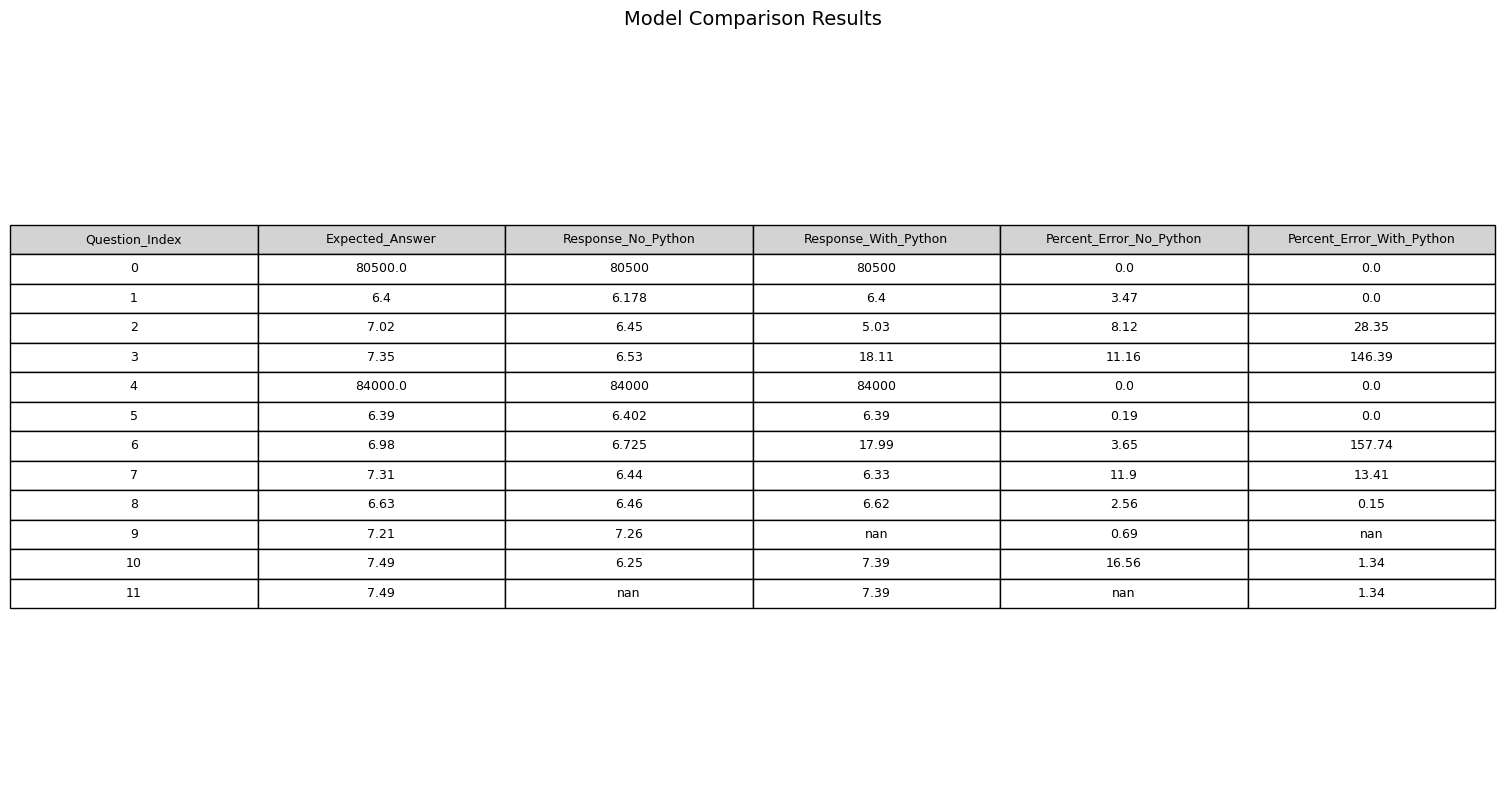

<Figure size 640x480 with 0 Axes>

: 

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(15, 8))

ax.axis('off')

table = ax.table(
    cellText=results_df.round(2).values,
    colLabels=results_df.columns,
    cellLoc='center',
    loc='center',
    colColours=['lightgray']*len(results_df.columns)
)

table.auto_set_font_size(False)
table.set_fontsize(9)
table.scale(1.2, 1.5)

plt.title('Model Comparison Results', pad=20, size=14)
plt.tight_layout()
plt.show()

plt.savefig(fname="brueggeman-questions-chart")